## GMM on iris data
The first step is to load the data from the "iris_data.csv" to a numpy array.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
np.random.seed(0)

X = np.genfromtxt("iris_data.csv", delimiter=',')
print(X.shape)

n = X.shape[0]
p = X.shape[1]

(150, 4)


We first take a look at how the data look like using TSNE.

[]

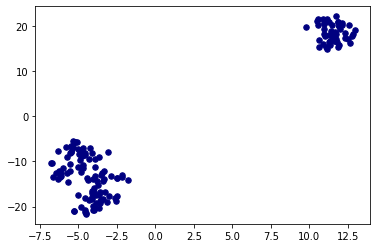

In [2]:
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color='navy', s=30)
plt.plot()

There are roughly 3 clusters.

$\lambda_i$ are initialized uniformly. Each is $\frac{1}{3}$.

$\mu_i$ are initialized with 3 samples randomly selected from $X$.

$\sigma^2_i$ are uniformly sampled from $(1., 2.)$.

In [3]:
k = 3
lambdas = np.ones((k))/k
mus = X[np.random.choice(n, k), :]
#mus = np.array([[1., 1.], [1., 21.], [41, 1]])
sigma2s = np.random.random_sample(k) + 1. # initial variance cannot be too small

print(lambdas)
print(mus)
print(sigma2s)

[0.33333333 0.33333333 0.33333333]
[[6.3 3.3 6.  2.5]
 [5.  2.3 3.3 1. ]
 [5.8 2.8 5.1 2.4]]
[1.72769634 1.74223798 1.30698606]


Furthermore, we define a pdf function here to calculate the likelihood.

In [4]:
def log_pdf(X, mean, variance):
    n = len(X)
    log_pdf_list = []
    for i in range(n):
        log_pdf = np.log(1. / (2. * np.pi * variance)**(p/2)) - 1./(2.*variance) * np.matmul((X[i]-mean).T, X[i]-mean)
        log_pdf_list.append(log_pdf)
    return np.array(log_pdf_list)

Now we start to fit the Gaussian Mixture Model (GMM):

### Expectation Step

Compute $P_i(z_i=j|X_i, \theta^{t-1})=\frac{\lambda_j^{t-1}N(X_i;\mu_j^{t-1}, (\sigma_j^{t-1})^2)}{\sum_{k=1}^3\lambda_k^{t-1}N(X_i;\mu_k^{t-1}, (\sigma_k^{t-1})^2)}=p_i^{t-1}(j)$

### Likelihood for step t-1

$\ell(\theta^{t-1};X)=L(P(Z|X,\theta^{t-1}), \theta^{t-1})=\sum_{i=1}^n\sum_{z_i=1}^3 P(z_i|X_i, \theta^{t-1}) \log \frac{P(X_i, z_i|\theta^{t-1})}{P(z_i|X_i, \theta^{t-1})}=\sum_{i=1}^n\sum_{j=1}^3 p^{t-1}_i(j)\log \frac{P(X_i, z_i=j|\theta^{t-1})}{p^{t-1}_i(j)}=$
$\sum_{i=1}^n \log P(X_i|\theta^{t-1})=\sum_{i=1}^n \log \sum_{j=1}^3 P(X_i, z_i=j|\theta^{t-1})$

### Maximization Step

$\hat{\mu}_j=\frac{\sum_{i=1}^n p_i^{t-1}(j)X_i}{\sum_{i=1}^n p_i^{t-1}(j)}$

$\hat{\sigma}_j^2=\frac{\sum_{i=1}^n p_i^{t-1}(j)(X_i-\hat{\mu}_j)^T(X_i-\hat{\mu}_j)}{p\sum_{i=1}^n p_i^{t-1}(j)}$

In [5]:
eps = 1e-6
log_likelihoods = []

clusters = np.zeros(n, dtype=int)

for step in range(30):
    # Expectation step (p_i^{t-1}(j)): 
    ## sub-step 1: Compute N(X_i;\mu_j^{t-1}, (\sigma_j^{t-1})^2) for each X_i. (likelihood)
    log_lld = []
    for j in range(k):
        log_lld.append(log_pdf(X, mus[j], sigma2s[j]))
    log_lld = np.array(log_lld)
    max_log_lld = np.amax(log_lld, axis=0)
    ## sub-step 2: Compute p_i^{t-1}(j)
    p_ij = np.zeros((n, k), dtype=np.float32)
    for i in range(n):
        norm_term = 0.
        for j in range(k):
            norm_term += lambdas[j] * np.exp(log_lld[j, i]-max_log_lld[i])
        for j in range(k):
            p_ij[i, j] = lambdas[j] * np.exp(log_lld[j, i]-max_log_lld[i]) / norm_term
        clusters[i] = np.argmax(p_ij[i, :])
    
    # log-Likelihood
    lld = 0.
    for i in range(n):
        norm_term = 0.
        for j in range(k):
            norm_term += lambdas[j] * np.exp(log_lld[j, i]-max_log_lld[i])
        lld += np.log(norm_term) + max_log_lld[i]
    log_likelihoods.append([step-1, lld])
    
    # Maximization step (Update \lambda_j, \mu_j, \sigma^2_j)
    for j in range(k):
        # update \lambda's
        sum_weight = 0.
        for i in range(n):
            sum_weight += p_ij[i, j]
        lambdas[j] = sum_weight / n
        
        # update means
        sum_weighted_mean = np.zeros(p)
        for i in range(n):
            sum_weighted_mean += p_ij[i, j] * X[i]
        mus[j] = sum_weighted_mean / sum_weight
        
        # update variance
        sum_weighted_variance = 0.
        for i in range(n):
            sum_weighted_variance += p_ij[i, j] * np.matmul((X[i] - mus[j]).T, X[i] - mus[j])
        sigma2s[j] = sum_weighted_variance / (sum_weight * p)

print(lambdas)
print(mus)
print(sigma2s)

[0.25272308 0.33333333 0.41394358]
[[6.84638553 3.0736805  5.73051652 2.07463051]
 [5.006      3.418      1.464      0.244     ]
 [5.90521778 2.74886893 4.40261171 1.43262594]]
[0.16292631 0.076202   0.16327054]


### Plot the clustering results

[]

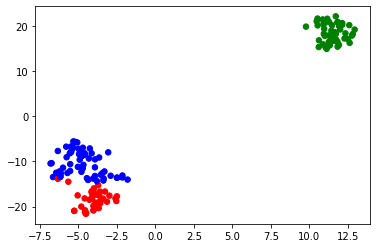

In [6]:
colors = ['red', 'green', 'blue']
assigned_colors = []
for i in range(n):
    assigned_colors.append(colors[clusters[i]])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=assigned_colors, s=30)
plt.plot()

### Plot log-likelihood vs step

Text(0.5, 1.0, 'log likelihood')

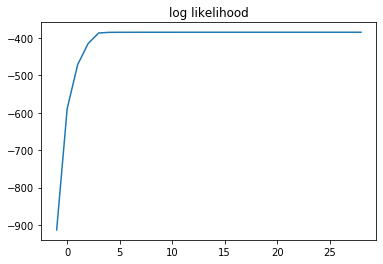

In [7]:
log_likelihoods = np.array(log_likelihoods)

plt.plot(log_likelihoods[:, 0], log_likelihoods[:, 1])
plt.title("log likelihood")

In [8]:
print(clusters)

best_acc = 0.
for l0 in range(3):
    for l1 in range(3):
        if l0 != l1:
            for l2 in range(3):
                if l2 != l0 and l2 != l1:
                    acc = 0.
                    for i in range(n):
                        if i < 50:
                            if clusters[i] == l0: acc += 1
                        elif i < 100:
                            if clusters[i] == l1: acc += 1
                        elif i < 150:
                            if clusters[i] == l2: acc += 1
                    acc /= n
                    if acc > best_acc:
                        best_acc = acc
print("Best accuracy: {} %".format(best_acc * 100))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
Best accuracy: 89.33333333333333 %
